# nr catalogue

collect together all nr data and save them read to be read by a fitting code

In [1]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({"font.size":16})

<Figure size 432x288 with 0 Axes>

In [2]:
import pandas as pd
import glob
import os
import numpy as np
import phenom
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [54]:
import scipy.integrate
import scipy.optimize

from functools import partial

# def dephasing(iphi1, iphi2, win1, win2, z):
#     dt, dphi = z
#     return quad(lambda t: np.abs((iphi1(t)-iphi2(t+dt)+dphi)),win1,win2)[0]


def dephasing(iphi1, iphi2, win1, win2, z):
    """
    ty TD
    """
    dt, dphi = z

    t1 = lambda t: iphi1(t)
    t2 = lambda t, dt, dphi: iphi2(t+dt)+dphi

    integrand = lambda t: np.abs(t1(t)-t2(t, dt, dphi)) 

    return scipy.integrate.quad(integrand, win1, win2, limit=200)[0]


In [4]:
data_dirs = {
    'bam':"/Users/sebastian.khan/personal/data/bam_dec_2022",
    'sxs':"/Users/sebastian.khan/personal/data/sxs_dec_2022",
    'rit':"/Users/sebastian.khan/personal/data/rit_dec_2022",
    'gtech':"/Users/sebastian.khan/personal/data/gtech_dec_2022",
}

In [5]:
metadata_files = {}
for k in data_dirs:
    metadata_files[k] = glob.glob(os.path.join(data_dirs[k], '*.csv'))[0]

In [6]:
metadata_files

{'bam': '/Users/sebastian.khan/personal/data/bam_dec_2022/metadata.csv',
 'sxs': '/Users/sebastian.khan/personal/data/sxs_dec_2022/metadata.csv',
 'rit': '/Users/sebastian.khan/personal/data/rit_dec_2022/metadata.csv',
 'gtech': '/Users/sebastian.khan/personal/data/gtech_dec_2022/metadata.csv'}

In [7]:
dfs = []
for k in metadata_files.keys():
    dfs.append(pd.read_csv(metadata_files[k]))

In [8]:
df = pd.concat(dfs).reset_index(drop=True)
df = df.set_index('name')

In [9]:
df.shape

(90, 1)

In [10]:
df

q
name                      
q4a0_T_80_320         4.00
q4a0_T_96_384         4.00
q4a0_T_112_448        4.00
q8a0a0c05_T_80_420    8.00
q8a0a0_T_96_504n512   8.00
...                    ...
GT0577                5.00
GT0824                5.50
GT0604                6.00
GT0568               10.00
GT0601               15.04

[90 rows x 1 columns]

In [11]:
df[df['q']==32.]

q
name                   
RIT-BBH-0792-n120  32.0
RIT-BBH-1025-n100  32.0

In [12]:
df.reset_index().groupby(by='q').count().sort_values(by='name', ascending=False)

name
q           
4.00       7
10.00      6
1.00       5
2.00       5
5.00       5
18.00      3
15.00      3
8.00       3
32.00      2
6.00       2
3.60       1
3.80       1
3.70       1
3.30       1
3.50       1
3.40       1
3.20       1
3.10       1
3.90       1
4.30       1
4.10       1
4.20       1
2.90       1
4.40       1
4.50       1
5.50       1
7.00       1
15.04      1
63.99      1
3.00       1
2.80       1
1.10       1
2.70       1
1.15       1
1.18       1
1.20       1
1.25       1
1.30       1
1.33       1
1.40       1
1.45       1
1.50       1
1.60       1
1.70       1
1.75       1
1.80       1
1.82       1
1.90       1
2.05       1
2.10       1
2.20       1
2.25       1
2.30       1
2.35       1
2.40       1
2.41       1
2.50       1
2.60       1
127.99     1

In [13]:
df.loc['GT0824']

q    5.5
Name: GT0824, dtype: float64

<AxesSubplot:ylabel='Frequency'>

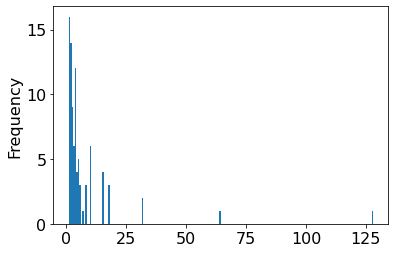

In [14]:
df.q.plot.hist(bins=200)

In [15]:
nr_files = {}
for k in data_dirs:
    nr_files[k] = glob.glob(os.path.join(data_dirs[k], '*.npy'))

In [16]:
# setup data array and metadata dataframe with the same indices

In [17]:
data_list=[]
names=[]
qs=[]

frings=[]
fdamps=[]

for k in nr_files.keys():
    for nr_file in nr_files[k]:
        simname = nr_file.split("/")[-1].split(".npy")[0]
        names.append(simname)
        q = df.loc[simname]['q']
        qs.append(q)
        data_list.append(np.load(nr_file))
        
        eta = phenom.eta_from_q(q)
        fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
        fring = phenom.remnant.fring(eta, 0, 0, fin_spin)
        fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)

        frings.append(fring)
        fdamps.append(fdamp)
        

In [18]:
df_pars = pd.DataFrame({'name':names,'q':qs, 'fring':frings, 'fdamp':fdamps})

In [19]:
df_pars

name     q     fring     fdamp
0   q18a0a0c025_96_fine  18.0  0.063334  0.014140
1         q4a0_T_96_384   4.0  0.074330  0.014004
2   q8a0a0_T_96_504n512   8.0  0.067697  0.014104
3    q8a0a0c05_T_80_420   8.0  0.067697  0.014104
4     q10c25e_T_112_448  10.0  0.066184  0.014119
..                  ...   ...       ...       ...
85               GT0565   2.5  0.080296  0.013861
86               GT0759   3.2  0.077075  0.013944
87               GT0374   1.6  0.085626  0.013689
88               GT0604   6.0  0.070079  0.014075
89               GT0758   3.1  0.077482  0.013935

[90 rows x 4 columns]

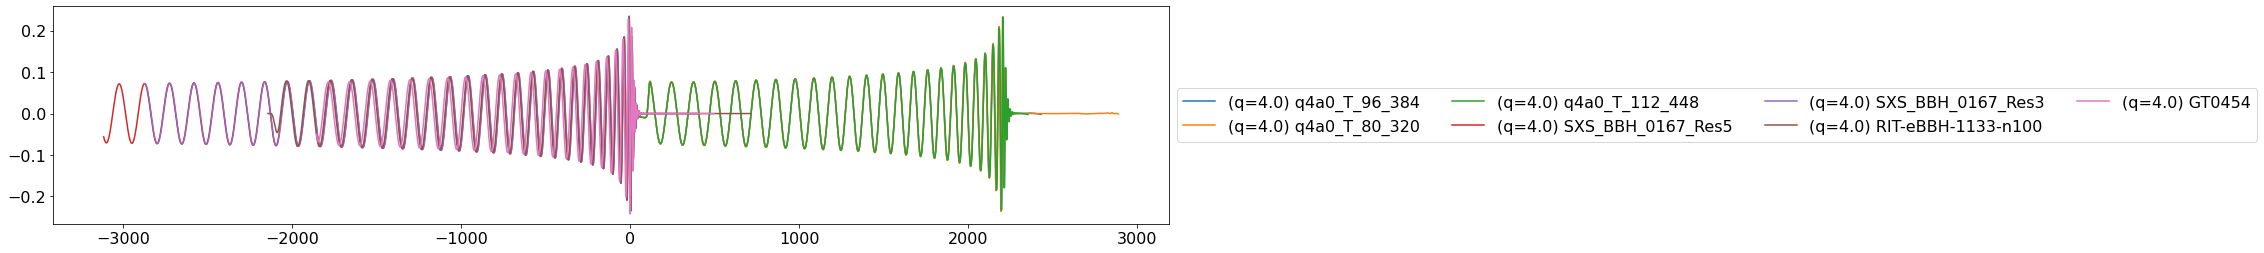

In [20]:
plt.figure(figsize=(20,4))
# for i in range(len(data_list)):
for i in df_pars[df_pars['q']==4].index:
    name = df_pars.iloc[i]['name']
    q = df_pars.iloc[i]['q']
    plt.plot(data_list[i][:,0], data_list[i][:,1], label=f"(q={q}) {name}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)

In [21]:
# aligning waveforms so that the amplitude is at t=0
# and so that the phase is zero at t=0

In [22]:
data_list_t0 = []
for i in range(len(data_list)):
    t = data_list[i][:,0]
    s_re = data_list[i][:,1]
    s_im = data_list[i][:,2]
    s = s_re - 1.j * s_im
    amp = np.abs(s)
    
    peak_idx = np.argmax(amp)
    t_peak = t[peak_idx]
    t = t - t_peak
    
    amp = np.abs(s)
    
    phi = np.unwrap(np.angle(s))
    phi0 = phi[peak_idx]
    phi = phi-phi0
    
    s = amp * np.exp(-1.j*phi)
    s_re = np.real(s)
    s_im = np.imag(s)
    
    d = np.column_stack((t, s_re, s_im))
    data_list_t0.append(d)

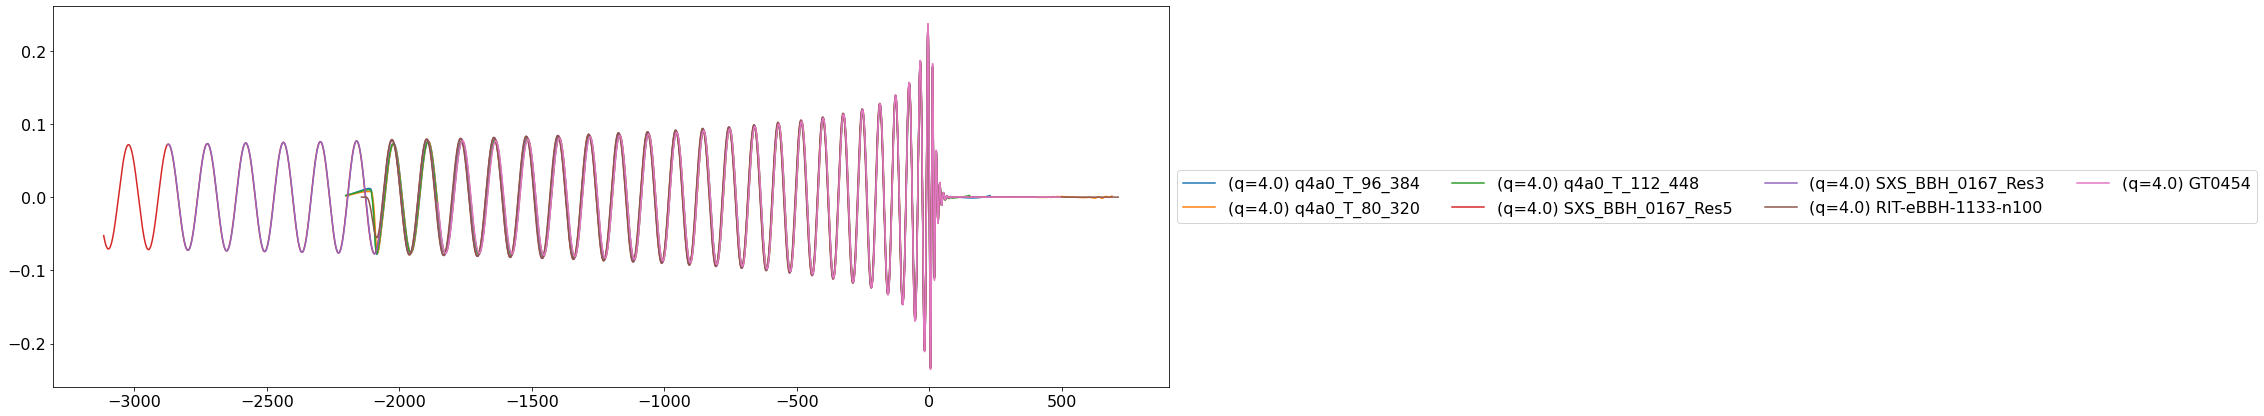

In [23]:
plt.figure(figsize=(20,7))
# for i in range(len(data_list_t0)):
for i in df_pars[df_pars['q']==4].index:
# for i in df_pars[df_pars['q']==32].index:
# for i in df_pars[df_pars['q']==10].index:
    name = df_pars.iloc[i]['name']
    q = df_pars.iloc[i]['q']
    t = data_list_t0[i][:,0]
    s = data_list_t0[i][:,1] - 1.j * data_list_t0[i][:,2]
    
    
    
    # plt.plot(t, np.abs(s)/phenom.eta_from_q(q), label=f"(q={q}) {name}")
    # plt.plot(t, np.abs(s), label=f"(q={q}) {name}")
    # plt.plot(t, np.real(s), label=f"(q={q}) {name}")
    plt.plot(t, np.imag(s), label=f"(q={q}) {name}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)
# plt.xlim(-100, 100)
# plt.yscale('log')
# plt.ylim(1e-4, 1)
# plt.ylim(0.1, 2)

In [24]:
tlens = []
for i in range(len(data_list_t0)):
    tlens.append(data_list_t0[i][0,0])
tlens=np.array(tlens)

In [25]:
t_last = []
for i in range(len(data_list_t0)):
    t_last.append(data_list_t0[i][-1,0])
t_last=np.array(t_last)

In [26]:
df_pars['duration'] = np.abs(tlens)

In [27]:
df_pars['t_final'] = np.abs(t_last)

In [28]:
df_pars

name     q     fring     fdamp  duration  t_final
0   q18a0a0c025_96_fine  18.0  0.063334  0.014140    1020.0    465.8
1         q4a0_T_96_384   4.0  0.074330  0.014004    2202.1    229.5
2   q8a0a0_T_96_504n512   8.0  0.067697  0.014104     953.1    430.4
3    q8a0a0c05_T_80_420   8.0  0.067697  0.014104     941.9    259.8
4     q10c25e_T_112_448  10.0  0.066184  0.014119    1157.7    121.6
..                  ...   ...       ...       ...       ...      ...
85               GT0565   2.5  0.080296  0.013861    1484.2    465.0
86               GT0759   3.2  0.077075  0.013944     694.3    369.5
87               GT0374   1.6  0.085626  0.013689     860.9    692.5
88               GT0604   6.0  0.070079  0.014075    1496.1    460.8
89               GT0758   3.1  0.077482  0.013935     682.9    380.9

[90 rows x 6 columns]

In [29]:
df_pars[df_pars['duration'] >= 900].shape

(57, 6)

In [30]:
df_pars[df_pars['duration'] >= 900]

name       q     fring     fdamp  duration  t_final
0    q18a0a0c025_96_fine   18.00  0.063334  0.014140    1020.0    465.8
1          q4a0_T_96_384    4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512    8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420    8.00  0.067697  0.014104     941.9    259.8
4      q10c25e_T_112_448   10.00  0.066184  0.014119    1157.7    121.6
5          q4a0_T_80_320    4.00  0.074330  0.014004    2199.5    689.1
6        q18a0a0c025_144   18.00  0.063334  0.014140    1028.3     88.8
7   q8a0a0_T_112_588n768    8.00  0.067697  0.014104     957.9    207.8
8        q18a0a0c025_120   18.00  0.063334  0.014140    1027.5    174.7
9         q4a0_T_112_448    4.00  0.074330  0.014004    2202.5    151.8
10     SXS_BBH_0107_Res3    5.00  0.071862  0.014048    7440.1    449.9
11     SXS_BBH_0167_Res5    4.00  0.074330  0.014004    3115.7    404.1
12     SXS_BBH_0107_Res5    5.00  0.071862  0.014048    7465.5    451.5
13     SXS_BBH_0107_Res4    5.00  0.071862  0.014048    7457.2    449.8
14     SXS_BBH_0167_Res3    4.00  0.074330  0.014004    2874.0    403.8
15     SXS_BBH_0169_Res4    2.00  0.083149  0.013774    3458.2    406.7
16     SXS_BBH_0169_Res5    2.00  0.083149  0.013774    3468.3    406.6
17     SXS_BBH_0169_Res3    2.00  0.083149  0.013774    3088.2    406.7
18     SXS_BBH_0180_Res3    1.00  0.088087  0.013596    9359.5    236.6
19     SXS_BBH_0303_Res3   10.00  0.066184  0.014119    3397.6    498.9
20     SXS_BBH_0180_Res2    1.00  0.088087  0.013596    9354.6    236.8
21     SXS_BBH_0303_Res4   10.00  0.066184  0.014119    3433.2    499.1
22     SXS_BBH_0180_Res4    1.00  0.088087  0.013596    9270.5    236.4
23     SXS_BBH_0303_Res5   10.00  0.066184  0.014119    3461.4    499.7
24     RIT-BBH-0416-n140    7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100    1.18  0.087761  0.013608    1602.1    396.2
26     RIT-BBH-0152-n120    5.00  0.071862  0.014048    4000.5    557.5
27     RIT-BBH-1916-n100   63.99  0.060593  0.014154    1039.2    302.7
28    RIT-eBBH-1090-n100    1.00  0.088087  0.013596    1493.9    362.0
29    RIT-eBBH-1133-n100    4.00  0.074330  0.014004    2143.1    712.8
30    RIT-eBBH-1241-n100    1.33  0.087138  0.013633    1520.6    335.3
31     RIT-BBH-0942-n120   15.00  0.064066  0.014135    1162.8    330.2
32     RIT-BBH-0112-n100    1.00  0.088087  0.013596   16963.4    419.5
33     RIT-BBH-0139-n140    2.41  0.080777  0.013847    2736.9    423.5
34     RIT-BBH-0373-n140   15.00  0.064066  0.014135    2725.0    437.6
35     RIT-BBH-0792-n120   32.00  0.061687  0.014149    1558.3    191.2
36     RIT-BBH-0090-n100    6.00  0.070079  0.014075    1746.7    392.9
37     RIT-BBH-1076-n100  127.99  0.060036  0.014156    1310.3    331.4
38     RIT-BBH-1020-n144    1.82  0.084262  0.013737    1368.2    249.8
39    RIT-eBBH-1200-n100    2.00  0.083149  0.013774    1637.8    318.1
40     RIT-BBH-0978-n144   10.00  0.066184  0.014119    1963.0    393.4
41     RIT-BBH-1025-n100   32.00  0.061687  0.014149    1474.0    240.2
42     RIT-BBH-0957-n084   15.00  0.064066  0.014135    1038.4    363.1
44                GT0379    2.20  0.081956  0.013812     936.3    616.9
45                GT0378    2.05  0.082845  0.013784     915.7    637.3
50                GT0757    2.25  0.081668  0.013820    1429.1    420.0
52                GT0380    2.35  0.081105  0.013837     957.9    595.3
57                GT0454    4.00  0.074330  0.014004    1855.1    495.1
58                GT0898    1.20  0.087693  0.013611    1793.9    286.8
62                GT0446    2.00  0.083149  0.013774    1378.6    470.3
63                GT0453    3.00  0.077907  0.013924    1599.7    549.9
65                GT0727    1.75  0.084699  0.013722    1330.0    418.7
69                GT0477    1.50  0.086221  0.013667    1286.6    361.9
70                GT0738    1.25  0.087500  0.013619    1252.6    395.9
78                GT0577    5.00  0.071862  0.014048    1281

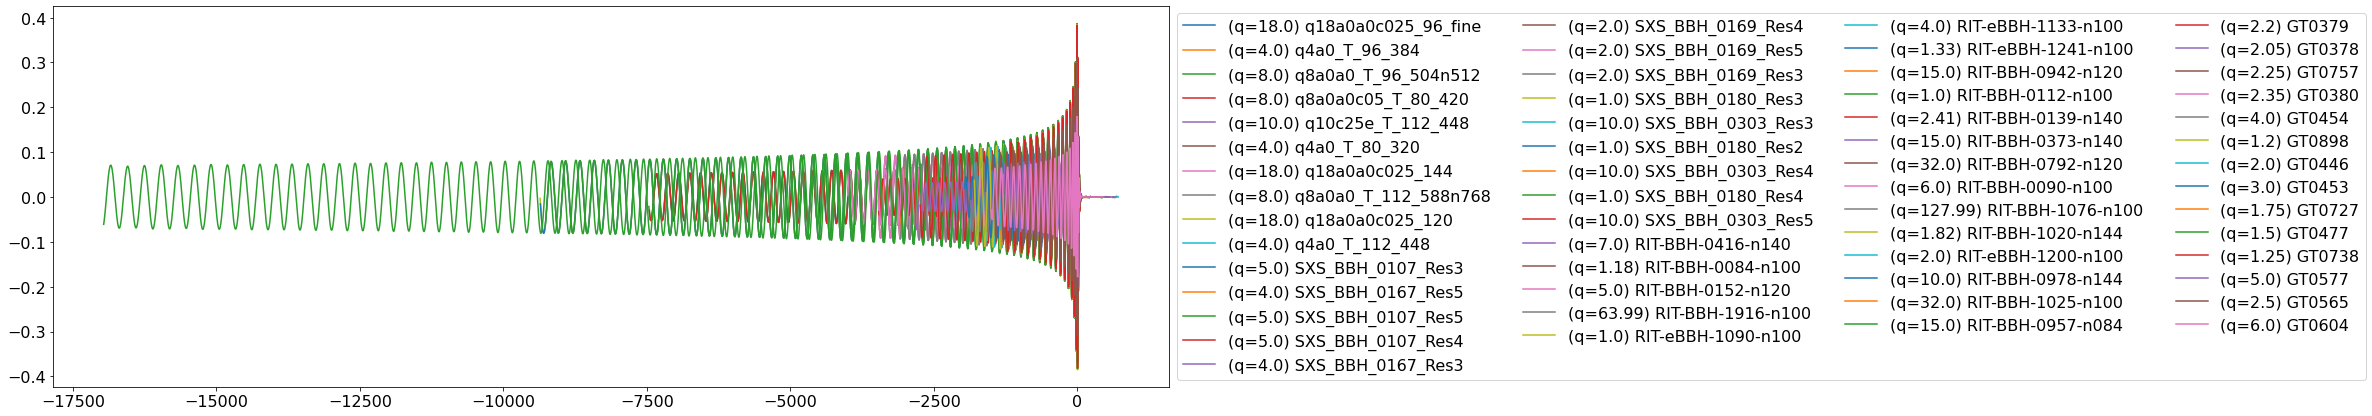

In [31]:
plt.figure(figsize=(20,7))
for i in df_pars[df_pars['duration'] >= 900].index:
    name = df_pars.iloc[i]['name']
    q = df_pars.iloc[i]['q']
    t = data_list_t0[i][:,0]
    s = data_list_t0[i][:,1] - 1.j * data_list_t0[i][:,2]
    
    
    # plt.plot(t, np.abs(s)/phenom.eta_from_q(q), label=f"(q={q}) {name}")
    # plt.plot(t, np.abs(s), label=f"(q={q}) {name}")
    # plt.plot(t, np.real(s), label=f"(q={q}) {name}")
    plt.plot(t, np.imag(s), label=f"(q={q}) {name}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)
# plt.xlim(-100, 100)
# plt.yscale('log')
# plt.ylim(1e-4, 1)
# plt.ylim(0.1, 2)

In [32]:
# lets set a minimum length
T_MIN = 900

# set a maximum mass-ratio
Q_MAX = 32

idx_t_min = df_pars[(df_pars['duration'] >= T_MIN) & (df_pars['q'] <= Q_MAX)].index

In [33]:
idx_t_min.shape

(55,)

In [34]:
df_pars_curated = df_pars.iloc[idx_t_min].reset_index(drop=True)

In [35]:
df_pars_curated

name      q     fring     fdamp  duration  t_final
0    q18a0a0c025_96_fine  18.00  0.063334  0.014140    1020.0    465.8
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8
4      q10c25e_T_112_448  10.00  0.066184  0.014119    1157.7    121.6
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1
6        q18a0a0c025_144  18.00  0.063334  0.014140    1028.3     88.8
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8
8        q18a0a0c025_120  18.00  0.063334  0.014140    1027.5    174.7
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8
10     SXS_BBH_0107_Res3   5.00  0.071862  0.014048    7440.1    449.9
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1
12     SXS_BBH_0107_Res5   5.00  0.071862  0.014048    7465.5    451.5
13     SXS_BBH_0107_Res4   5.00  0.071862  0.014048    7457.2    449.8
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8
15     SXS_BBH_0169_Res4   2.00  0.083149  0.013774    3458.2    406.7
16     SXS_BBH_0169_Res5   2.00  0.083149  0.013774    3468.3    406.6
17     SXS_BBH_0169_Res3   2.00  0.083149  0.013774    3088.2    406.7
18     SXS_BBH_0180_Res3   1.00  0.088087  0.013596    9359.5    236.6
19     SXS_BBH_0303_Res3  10.00  0.066184  0.014119    3397.6    498.9
20     SXS_BBH_0180_Res2   1.00  0.088087  0.013596    9354.6    236.8
21     SXS_BBH_0303_Res4  10.00  0.066184  0.014119    3433.2    499.1
22     SXS_BBH_0180_Res4   1.00  0.088087  0.013596    9270.5    236.4
23     SXS_BBH_0303_Res5  10.00  0.066184  0.014119    3461.4    499.7
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2
26     RIT-BBH-0152-n120   5.00  0.071862  0.014048    4000.5    557.5
27    RIT-eBBH-1090-n100   1.00  0.088087  0.013596    1493.9    362.0
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2
31     RIT-BBH-0112-n100   1.00  0.088087  0.013596   16963.4    419.5
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2
35     RIT-BBH-0090-n100   6.00  0.070079  0.014075    1746.7    392.9
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8
37    RIT-eBBH-1200-n100   2.00  0.083149  0.013774    1637.8    318.1
38     RIT-BBH-0978-n144  10.00  0.066184  0.014119    1963.0    393.4
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2
40     RIT-BBH-0957-n084  15.00  0.064066  0.014135    1038.4    363.1
41                GT0379   2.20  0.081956  0.013812     936.3    616.9
42                GT0378   2.05  0.082845  0.013784     915.7    637.3
43                GT0757   2.25  0.081668  0.013820    1429.1    420.0
44                GT0380   2.35  0.081105  0.013837     957.9    595.3
45                GT0454   4.00  0.074330  0.014004    1855.1    495.1
46                GT0898   1.20  0.087693  0.013611    1793.9    286.8
47                GT0446   2.00  0.083149  0.013774    1378.6    470.3
48                GT0453   3.00  0.077907  0.013924    1599.7    549.9
49                GT0727   1.75  0.084699  0.013722    1330.0    418.7
50                GT0477   1.50  0.086221  0.013667    1286.6    361.9
51                GT0738   1.25  0.087500  0.013619    1252.6    395.9
52                GT0577   5.00  0.071862  0.014048    1281.6    574.2
53                GT0565   2.50  0.080296  0.013861    1484.2    465.0
54                GT0604   6.00  0.070079  0.014075    1496.1    460.8

In [36]:
# now we resample onto a common time

In [37]:
df_pars_curated['duration'].min()

915.7000000002082

In [38]:
T_JUNK = 140

T_START = -np.int32(df_pars_curated['duration'].min() - T_JUNK)
T_END = np.int32(df_pars_curated['t_final'].min() - 1)
# T_END = 120
DT = 0.1

In [39]:
T_START

-775

In [40]:
T_END

87

In [41]:
common_times = np.arange(T_START, T_END, DT)

In [42]:
def resample(times, strain, new_times):
    amp = np.abs(strain)
    phase = np.unwrap(np.angle(strain))
    amp = IUS(times, amp)(new_times)
    phase = IUS(times, phase)(new_times)
    phase = phase - phase[0]
    
    return amp * np.exp(-1.j*phase)

In [43]:
# data_list_t0_resampled contains the curated dataset
data_list_t0_resampled = []
for i in idx_t_min:
    times = data_list_t0[i][:,0]
    s_re = data_list_t0[i][:,1]
    s_im = data_list_t0[i][:,2]
    strain = s_re - 1.j*s_im
    strain = resample(times, strain, common_times)
    
    data_list_t0_resampled.append(strain)

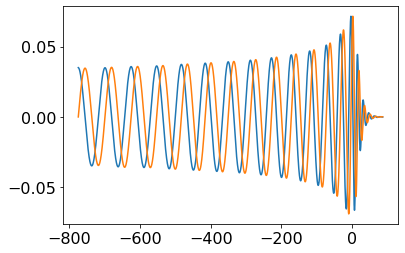

In [44]:
plt.plot(common_times, data_list_t0_resampled[0].real)
plt.plot(common_times, data_list_t0_resampled[0].imag)

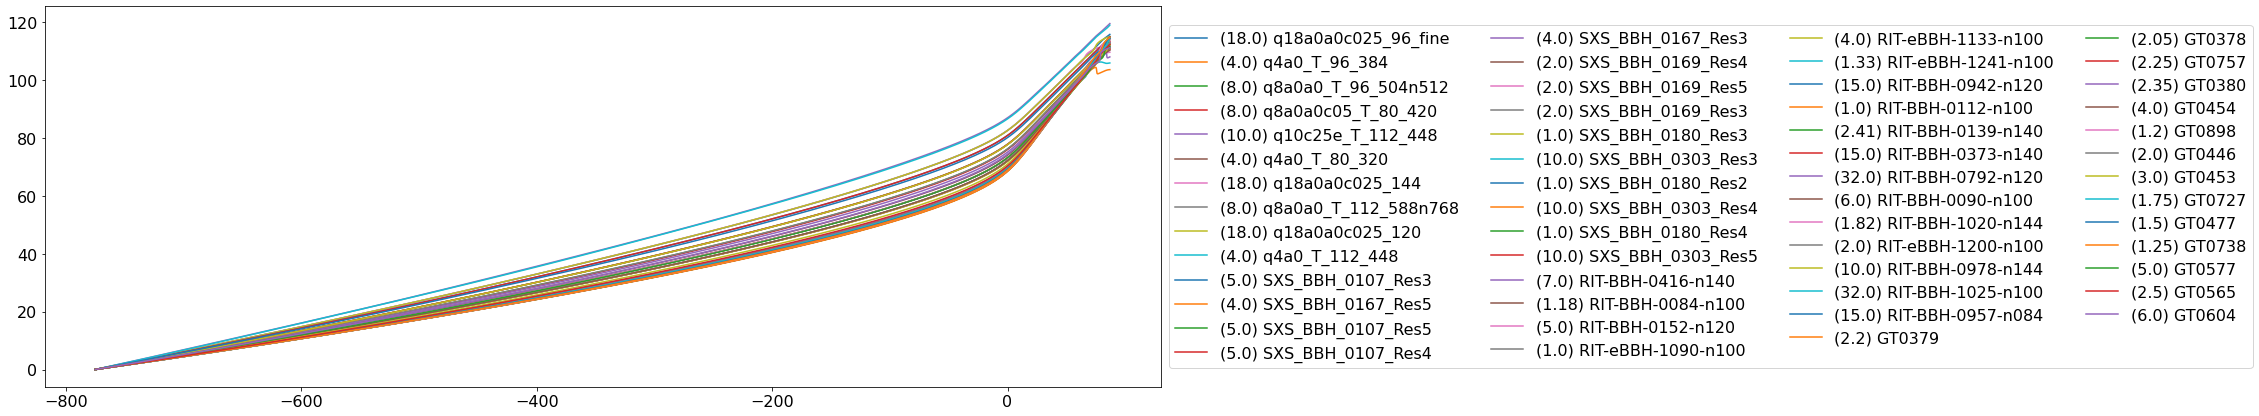

In [45]:
plt.figure(figsize=(20,7))
for i in range(len(data_list_t0_resampled)):
    label=f"({df_pars_curated.iloc[i]['q']}) {df_pars_curated.iloc[i]['name']}"
    # plt.plot(common_times, np.real(data_list_t0_resampled[i]), label=label)
    # plt.plot(common_times, np.imag(data_list_t0_resampled[i]), label=label)
    plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled[i])), label=label)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)
# plt.yscale('log')
# plt.xlim(-100, 100)

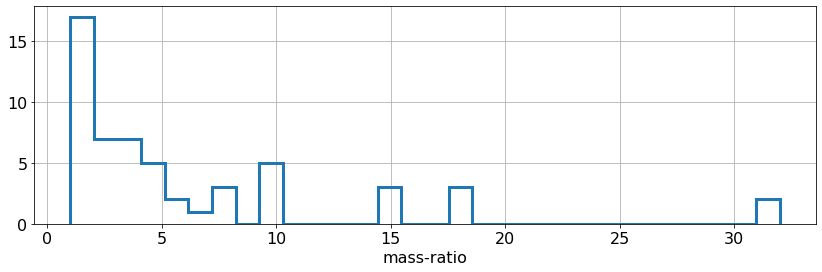

In [46]:
plt.figure(figsize=(14, 4))
plt.hist(df_pars_curated['q'], histtype='step', lw=3, bins=30)
plt.xlabel("mass-ratio")
plt.grid()

## align waveforms with same mass-ratio using a time and phase shift

In [51]:
def align_strains(times, h1, h2, t0, tlen):
    amp1 = np.abs(h1)
    phase1 = np.unwrap(np.angle(h1))
    
    amp2 = np.abs(h2)
    phase2 = np.unwrap(np.angle(h2))
    
    
    iphi1 = IUS(times, phase1)
    iphi2 = IUS(times, phase2)
    
    win1 = t0
    win2 = win1 + tlen
    
    partial_dephasing = partial(dephasing, iphi1, iphi2, win1, win2)
    
    sol=scipy.optimize.minimize(partial_dephasing, [0, 0], tol=1e-12)
    # print(sol.x)
    
    iamp2_shift = IUS(times-sol.x[0], amp2)
    iphi2_shift = IUS(times-sol.x[0], -(phase2+sol.x[1]))
    
    new_amp = iamp2_shift(times)
    new_phase = iphi2_shift(times)
    
    new_strain = new_amp * np.exp(-1.j * new_phase)
    return new_strain

In [48]:
df_pars_curated[df_pars_curated['q']==32]

name     q     fring     fdamp  duration  t_final
34  RIT-BBH-0792-n120  32.0  0.061687  0.014149    1558.3    191.2
39  RIT-BBH-1025-n100  32.0  0.061687  0.014149    1474.0    240.2

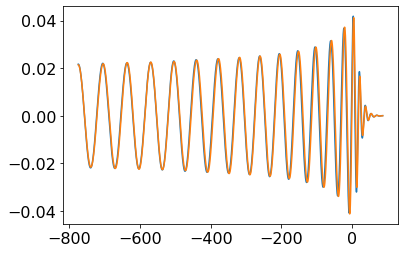

In [49]:
plt.plot(common_times, data_list_t0_resampled[34].real)
plt.plot(common_times, data_list_t0_resampled[39].real)


In [55]:
h1 = data_list_t0_resampled[34]
h2 = data_list_t0_resampled[39]
t0 = common_times[0]
tlen = 800
h2_new = align_strains(common_times, h1, h2, t0, tlen)

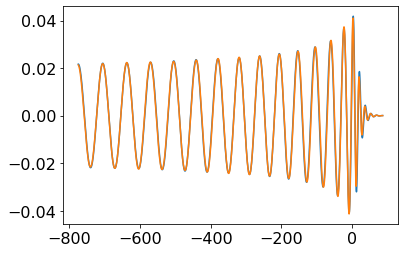

In [56]:
plt.plot(common_times, h1.real)
plt.plot(common_times, h2_new.real)
# plt.xlim(-100, 100)

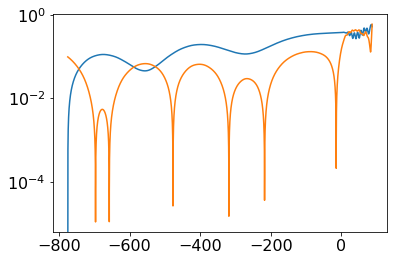

In [57]:
plt.plot(common_times, np.abs(np.unwrap(np.angle(h1))-np.unwrap(np.angle(h2))))
plt.plot(common_times, np.abs(np.unwrap(np.angle(h1))-np.unwrap(np.angle(h2_new))))
# plt.xlim(-100, 100)
plt.yscale('log')

In [58]:
%%time
data_list_t0_resampled_opt = data_list_t0_resampled.copy()

t0 = common_times[0]
tlen = 800

# unique_qs = df_pars_curated['q'].unique()[:1]
unique_qs = df_pars_curated['q'].unique()
for q in unique_qs:
    mask = df_pars_curated['q']==q
    num_qs = mask.sum()
    if num_qs > 1:
        # align
        print(q)
        idx = df_pars_curated[mask].index
        print(idx)
        h1 = data_list_t0_resampled[idx[0]]
        for i in idx[1:]:
            h2 = data_list_t0_resampled[i]
            h2_new = align_strains(common_times, h1, h2, t0, tlen)
            data_list_t0_resampled_opt[i] = h2_new
    else:
        # don't align
        pass

18.0
Int64Index([0, 6, 8], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/

4.0
Int64Index([1, 5, 9, 11, 14, 28, 45], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one wil

8.0
Int64Index([2, 3, 7], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/

10.0
Int64Index([4, 19, 21, 23, 38], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/

5.0
Int64Index([10, 12, 13, 26, 52], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/

2.0
Int64Index([15, 16, 17, 37, 47], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/

1.0
Int64Index([18, 20, 22, 27, 31], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]


15.0
Int64Index([30, 33, 40], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/

32.0
Int64Index([34, 39], dtype='int64')
6.0
Int64Index([35, 54], dtype='int64')


/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]
/var/folders/mq/kw_39j7d7n39tm1hyxg3sfx40000gn/T/ipykernel_51393/2405307357.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(integrand, win1, win2, limit=1000)[0]


CPU times: user 14min 53s, sys: 2.81 s, total: 14min 56s
Wall time: 14min 58s


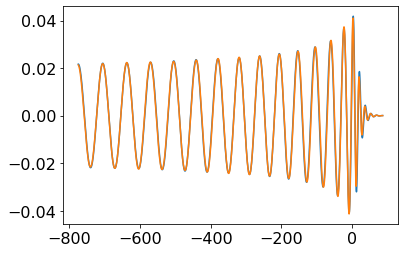

In [59]:
plt.plot(common_times, data_list_t0_resampled_opt[34].real)
plt.plot(common_times, data_list_t0_resampled_opt[39].real)

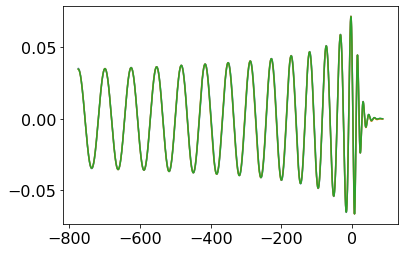

In [60]:
plt.plot(common_times, data_list_t0_resampled[0].real)
plt.plot(common_times, data_list_t0_resampled[6].real)
plt.plot(common_times, data_list_t0_resampled[8].real)
# plt.xlim(-10, 100)

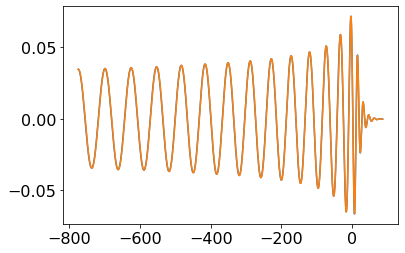

In [61]:
plt.plot(common_times, data_list_t0_resampled[6].real)
plt.plot(common_times, data_list_t0_resampled_opt[6].real)

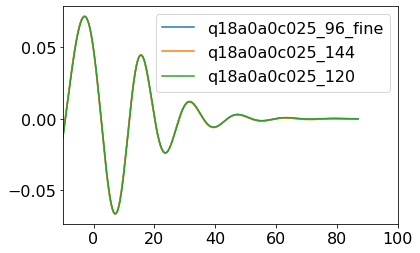

In [62]:
plt.plot(common_times, data_list_t0_resampled[0].real, label=df_pars_curated.iloc[0]['name'])
plt.plot(common_times, data_list_t0_resampled[6].real, label=df_pars_curated.iloc[6]['name'])
plt.plot(common_times, data_list_t0_resampled[8].real, label=df_pars_curated.iloc[8]['name'])
plt.xlim(-10, 100)
plt.legend()

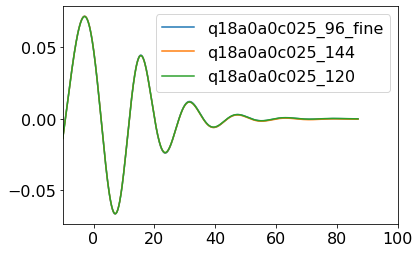

In [63]:
plt.plot(common_times, data_list_t0_resampled_opt[0].real, label=df_pars_curated.iloc[0]['name'])
plt.plot(common_times, data_list_t0_resampled_opt[6].real, label=df_pars_curated.iloc[6]['name'])
plt.plot(common_times, data_list_t0_resampled_opt[8].real, label=df_pars_curated.iloc[8]['name'])
plt.xlim(-10, 100)
plt.legend()

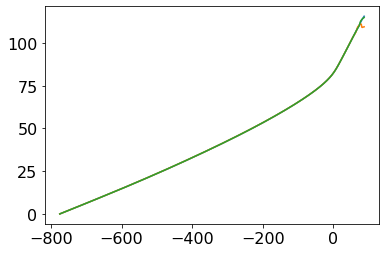

In [64]:
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled[0])))
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled[6])))
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled[8])))
# plt.xlim(-10, 100)

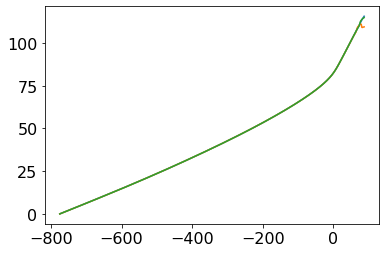

In [65]:
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled_opt[0])))
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled_opt[6])))
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled_opt[8])))
# plt.xlim(-10, 100)

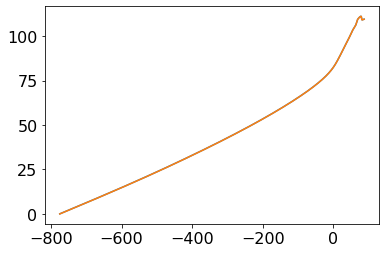

In [66]:
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled[6])))
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled_opt[6])))

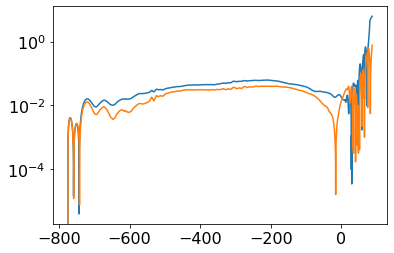

In [67]:
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled[6]))))
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled[8]))))
# plt.xlim(-10, 100)
plt.yscale('log')

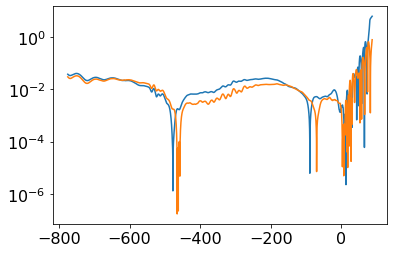

In [68]:
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled_opt[6]))))
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled_opt[8]))))
# plt.xlim(-10, 100)
plt.yscale('log')

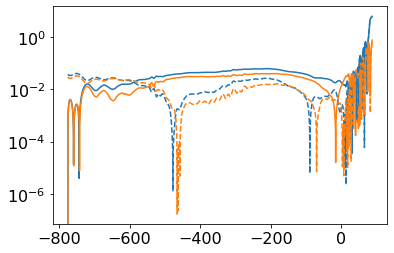

In [69]:
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled[6]))))
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled[8]))))
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled_opt[6]))), c='C0', ls='--')
plt.plot(common_times, np.abs(np.unwrap(np.angle(data_list_t0_resampled[0]))-np.unwrap(np.angle(data_list_t0_resampled_opt[8]))), c='C1', ls='--')
# plt.xlim(-10, 100)
plt.yscale('log')

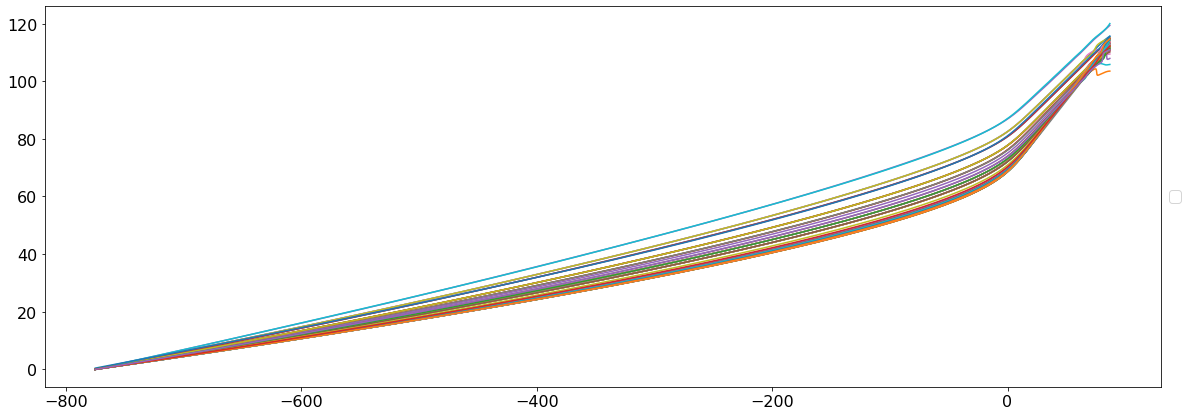

In [70]:
plt.figure(figsize=(20,7))
# for i in range(len(data_list_t0_resampled)):

# plt.plot(common_times, data_list_t0_resampled_opt[0].real)
# plt.plot(common_times, np.abs(data_list_t0_resampled_opt[0]))
plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled_opt[0])))

for i in range(1, len(data_list_t0_resampled_opt)):
    label=f"({df_pars_curated.iloc[i]['q']}) {df_pars_curated.iloc[i]['name']}"
    # plt.plot(common_times, data_list_t0_resampled_opt[i].real)
    # plt.plot(common_times, np.abs(data_list_t0_resampled_opt[i]))
    plt.plot(common_times, np.unwrap(np.angle(data_list_t0_resampled_opt[i])))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=4)
# plt.yscale('log')
# plt.xlim(-100, 100)

# output catalogue

In [71]:
# output_dir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [72]:
# df_pars.iloc[idx_t_min].to_csv(os.path.join(output_dir, "metadata.csv"), index=False)

In [73]:
# np.save(os.path.join(output_dir, "times"), common_times)

In [74]:
# this just aligns the amp and phase such that the peak amp is at t=0
# and the phase at the start of the data is 0
# # np.save(os.path.join(output_dir, "strains"), np.array(data_list_t0_resampled))

# this has the phase of duplicated nr waveforms aligned
# np.save(os.path.join(output_dir, "strains"), np.array(data_list_t0_resampled_opt))